In [2]:
import torch
import pandas as pd
import numpy as np
import anndata
from scipy.spatial import distance
import scanpy as sc
from collections import OrderedDict
from collections import defaultdict

In [125]:
import argparse


def get_parser():
    parser = argparse.ArgumentParser()
    
    parser.add_argument('-pretrain_batch', '--pretrain_batch',
                        type=int,
                        help='Batch size for pretraining. Default: no batch',
                        default=None)
    
    parser.add_argument('-pretrain','--pretrain',
                        type = bool,
                        default = True,
                        help='Pretrain model with autoencoder; otherwise load existing')
    
    parser.add_argument('-nepoch', '--epochs',
                        type=int,
                        help='number of epochs to train for',
                        default=30)

    parser.add_argument('-nepoch_pretrain', '--epochs_pretrain',
                        type=int,
                        help='number of epochs to pretrain for',
                        default=25)

    parser.add_argument('-source_file','--model_file',
                        type = str,
                        default = 'trained_models/source.pt',
                        help='location for storing source model and data')

    parser.add_argument('-lr', '--learning_rate',
                        type=float,
                        help='learning rate for the model, default=0.001',
                        default=0.001)

    parser.add_argument('-lrS', '--lr_scheduler_step',
                        type=int,
                        help='StepLR learning rate scheduler step, default=20',
                        default=20) 

    parser.add_argument('-lrG', '--lr_scheduler_gamma',
                        type=float,
                        help='StepLR learning rate scheduler gamma, default=0.5',
                        default=0.5)
  
    parser.add_argument('-seed', '--manual_seed',
                        type=int,
                        help='input for the manual seeds initializations',
                        default=3)
    
    parser.add_argument('--cuda',
                        action='store_true',
                        help='enables cuda')
    
    return parser

In [126]:
params, unknown= get_parser().parse_known_args()

In [127]:
params

Namespace(cuda=False, epochs=30, epochs_pretrain=25, learning_rate=0.001, lr_scheduler_gamma=0.5, lr_scheduler_step=20, manual_seed=3, model_file='trained_models/source.pt', pretrain=True, pretrain_batch=None)

In [128]:
if torch.cuda.is_available() and not params.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")
device = 'cuda:0' if torch.cuda.is_available() and params.cuda else 'cpu'
params.device = device

In [129]:
params

Namespace(cuda=False, device='cpu', epochs=30, epochs_pretrain=25, learning_rate=0.001, lr_scheduler_gamma=0.5, lr_scheduler_step=20, manual_seed=3, model_file='trained_models/source.pt', pretrain=True, pretrain_batch=None)

In [130]:
# coding=utf-8
import torch.utils.data as data
import numpy as np
import torch

'''
Class representing dataset for an single-cell experiment.
'''

IMG_CACHE = {}


class ExperimentDataset(data.Dataset):
    
    
    def __init__(self, x, cells, genes, metadata, y=[]):
        '''
        x: numpy array of gene expressions of cells (rows are cells)
        cells: cell IDs in the order of appearance
        genes: gene IDs in the order of appearance
        metadata: experiment identifier
        y: numeric labels of cells (empty list if unknown)
        '''
        super(ExperimentDataset, self).__init__()
        
        self.nitems = x.shape[0]
        if len(y)>0:
            print("== Dataset: Found %d items " % x.shape[0])
            print("== Dataset: Found %d classes" % len(np.unique(y)))
                
        if type(x)==torch.Tensor:
            self.x = x
        else:
            shape = x.shape[1]
            self.x = [torch.from_numpy(inst).view(shape).float() for inst in x]
        if len(y)==0:
            y = np.zeros(len(self.x), dtype=np.int64)
        self.y = tuple(y.tolist())
        self.xIDs = cells
        self.yIDs = genes
        self.metadata = metadata
            
    def __getitem__(self, idx):
        return self.x[idx].squeeze(), self.y[idx], self.xIDs[idx]
    #, self.yIDs[idx]

    def __len__(self):
        return self.nitems
    
    def get_dim(self):
        return self.x[0].shape[0]

In [16]:
adata=sc.read_h5ad("/Users/yaoestelle/scRNA_mit.h5ad")

In [47]:
sub = adata[:5000,:]

In [148]:
###Choose one cell type as unannotated
noT =  sub[:3000,]
y_annotated = np.array(noT.obs['dbscan'], dtype=np.int64)

In [149]:
annotated = ExperimentDataset(noT.X.toarray(), 
                              noT.obs_names, 
                              noT.var_names, 
                              'noTcell', y_annotated)

== Dataset: Found 3000 items 
== Dataset: Found 8 classes


In [150]:
Tcell =  sub[3000:,]
y_unannotated = np.array(Tcell.obs['dbscan'], dtype=np.int64)

In [151]:
unannotated = ExperimentDataset(Tcell.X.toarray(), 
                                Tcell.obs_names, 
                                Tcell.var_names, 
                                'Tcell', y_unannotated)

== Dataset: Found 2000 items 
== Dataset: Found 6 classes


In [152]:
pretrain_data = ExperimentDataset(Tcell.X.toarray(), 
                                  Tcell.obs_names, 
                                  Tcell.var_names, 'Tcell')

In [153]:
n_clusters = len(np.unique(unannotated.y))

In [154]:
n_clusters

6

In [162]:
Counter(unannotated.y)
Counter(annotated.y)

Counter({1: 1236, 2: 6, 3: 1232, 4: 317, 5: 4, 6: 200, 7: 3, 8: 2})

In [137]:
class EpochSampler(object):
    '''
    EpochSampler: yield permuted indexes at each epoch.
   
    __len__ returns the number of episodes per epoch (same as 'self.iterations').
    '''

    def __init__(self, indices):
        '''
        Initialize the EpochSampler object
        Args:
        - labels: an iterable containing all the labels for the current dataset
        samples indexes will be infered from this iterable.
        - iterations: number of epochs
        '''
        super(EpochSampler, self).__init__()
        self.indices = indices
        

    def __iter__(self):
        '''
        yield a batch of indexes
        '''
        
        while(True):
            shuffled_idx = self.indices[torch.randperm(len(self.indices))]
            
            yield shuffled_idx
            

    def __len__(self):
        '''
        returns the number of iterations (episodes) per epoch
        '''
        return self.iterations

In [138]:
import torch
from torch.utils.data import DataLoader ##prefetch by batch
#from model.epoch_sampler import EpochSampler


def init_labeled_loader(data, val_split = 0.8):
    """Initialize loaders for train and validation sets. 
    Class labels are used only
    for stratified sampling between train and validation set."""
    
    target = torch.tensor(list(data.y))
    uniq = torch.unique(target, sorted=True)
    
    class_idxs = list(map(lambda c: target.eq(c).nonzero(), uniq))
    class_idxs = [idx[torch.randperm(len(idx))] for idx in class_idxs]
    
    train_idx = torch.cat([idx[:int(val_split*len(idx))] for idx in class_idxs])
    val_idx = torch.cat([idx[int(val_split*len(idx)):] for idx in class_idxs])
    
    train_loader = DataLoader(data, 
                              batch_sampler=EpochSampler(train_idx),
                              pin_memory=True)
    
    val_loader = DataLoader(data, 
                            batch_sampler=EpochSampler(val_idx),
                            pin_memory=True)
    
    return train_loader, val_loader


def init_loader(datasets, val_split = 0.8):
    
    train_loader_all = []
    val_loader_all = []
    
    for data in datasets:
        
        curr_load_tr, curr_load_val = init_labeled_loader(data, val_split)
        train_loader_all.append(curr_load_tr)
        val_loader_all.append(curr_load_val)
    
    if val_split==1:
        val_loader_all = None
        
    return train_loader_all, val_loader_all


def init_data_loaders(labeled_data, unlabeled_data, 
                      pretrain_data, pretrain_batch, val_split):
    
    """Initialize loaders for pretraing, 
    training (labeled and unlabeled datasets) and validation. """
    
    train_loader, val_loader = init_loader(labeled_data, val_split)
    
    if not pretrain_data:
        pretrain_data = unlabeled_data
    
    pretrain_loader = torch.utils.data.DataLoader(dataset=pretrain_data, shuffle=True,
                                                  batch_size=pretrain_batch if pretrain_batch!=None else len(unlabeled_data.x))        
    test_loader = DataLoader(unlabeled_data, 
                            batch_sampler=EpochSampler(torch.randperm(len(unlabeled_data.x))),
                            pin_memory=True) 
    
    #test_loader,_ = init_loader([unlabeled_data], 1.0) # to reproduce results in the paper
    #test_loader = test_loader[0]
    return train_loader, test_loader, pretrain_loader, val_loader
           
           
def euclidean_dist(x, y):
    '''
    Compute euclidean distance between two tensors
    '''
    # x: N x D
    # y: M x D
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    if d != y.size(1):
        raise Exception

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)

In [139]:
import torch.nn as nn

def full_block(in_features, out_features, p_drop):
        return nn.Sequential(
            nn.Linear(in_features, out_features, bias=True),
            nn.LayerNorm(out_features),
            nn.ELU(),
            nn.Dropout(p=p_drop),
        )

class FullNet(nn.Module):
    '''
    '''
    def __init__(self, x_dim, hid_dim=64, z_dim=64, p_drop=0.2):
        super(FullNet, self).__init__()
        self.z_dim = z_dim
        
        self.encoder = nn.Sequential(
            full_block(x_dim, hid_dim, p_drop),
            full_block(hid_dim, z_dim, p_drop),
        )
        
        self.decoder = nn.Sequential(
            full_block(z_dim, hid_dim, p_drop),
            full_block(hid_dim, x_dim, p_drop),
        )
      
    def forward(self, x):
        
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return encoded, decoded

In [140]:
import torch
from torch.nn import functional as F

#from model.utils import euclidean_dist

def loss_task(encoded, prototypes, target, criterion='dist'):
    """Calculate loss.
    criterion: NNLoss - assign to closest prototype and calculate NNLoss
    dist - loss is distance to prototype that example needs to be assigned to
                and -distance to prototypes from other class
    """
    
    uniq = torch.unique(target, sorted=True)
    
    ###index of samples for each class of labels
    class_idxs = list(map(lambda c: target.eq(c).nonzero(), uniq))
    
    # prepare targets so they start from 0,1
    for idx,v in enumerate(uniq):
        target[target==v]=idx
    
    dists = euclidean_dist(encoded, prototypes)
    
    if criterion=='NNLoss':
       
        loss = torch.nn.NLLLoss()
        log_p_y = F.log_softmax(-dists, dim=1)
        
        loss_val = loss(log_p_y, target)
        _, y_hat = log_p_y.max(1)
        
    
    elif criterion=='dist':
        
        loss_val = torch.stack([dists[idx_example, idx_proto].mean(0) for idx_proto,idx_example in enumerate(class_idxs)]).mean()
        #loss_val1 = loss_val1/len(embeddings) 
        y_hat = torch.max(-dists,1)[1]
        
    acc_val = y_hat.eq(target.squeeze()).float().mean()    
        
    return loss_val, acc_val

def loss_test_nn(encoded, prototypes):
    dists = euclidean_dist(encoded, prototypes)
    min_dist = torch.min(dists, 1)
    
    y_hat = min_dist[1]
    args_uniq = torch.unique(y_hat, sorted=True)
    args_count = torch.stack([(y_hat==x_u).sum() for x_u in args_uniq])
    print(args_count)
    
    loss = torch.nn.NLLLoss()
    log_p_y = F.log_softmax(-dists, dim=1)
    print(log_p_y.shape)
        
    loss_val = loss(log_p_y, y_hat)
    _, y_hat = log_p_y.max(1)
    
    return loss_val, args_count


def loss_test_basic(encoded, prototypes):
    dists = euclidean_dist(encoded, prototypes)
    min_dist = torch.min(dists, 1)
    
    y_hat = min_dist[1]
    args_uniq = torch.unique(y_hat, sorted=True)
    args_count = torch.stack([(y_hat==x_u).sum() for x_u in args_uniq])
    #print(args_count)
    
    min_dist = min_dist[0] # get_distances
    
    #thr = torch.stack([torch.sort(min_dist[y_hat==idx_class])[0][int(len(min_dist[y_hat==idx_class])*0.9)] for idx_class in args_uniq])
    #loss_val = torch.stack([min_dist[y_hat==idx_class][min_dist[y_hat==idx_class]>=thr[idx_class]].mean(0) for idx_class in args_uniq]).mean()
    
    loss_val = torch.stack([min_dist[y_hat==idx_class].mean(0) for idx_class in args_uniq]).mean()
    
    #loss_val,_ = loss_task(encoded, prototypes, y_hat, criterion='dist') # same
    
    return loss_val, args_count

def loss_test(encoded, prototypes, tau):
    #prototypes = torch.stack(prototypes).squeeze() 
    loss_val_test, args_count = loss_test_basic(encoded, prototypes)
    
    
    ###Intracluster distance 
    if tau>0:
        dists = euclidean_dist(prototypes, prototypes)
        nproto = prototypes.shape[0]
        loss_val2 = - torch.sum(dists)/(nproto*nproto-nproto)
        
        loss_val_test += tau*loss_val2
        
    return loss_val_test, args_count

def reconstruction_loss(decoded, x):
    loss_func = torch.nn.MSELoss()
    loss_rcn = loss_func(decoded, x)
    #print('Reconstruction {}'.format(loss_rcn))
    
    return loss_rcn

In [141]:
import numpy as np
import torch
#from sklearn.cluster import k_means_
from sklearn.cluster import KMeans

#############################################
#############################################
def compute_landmarks_tr(embeddings, target, prev_landmarks=None, tau=0.2):
    """Computing landmarks of each class in the labeled meta-dataset. 
    
    Landmark is a closed form solution of 
    minimizing distance to the mean and maximizing distance to other landmarks. 
    
    If tau=0, landmarks are just mean of data points.
    
    embeddings: embeddings of the labeled dataset
    target: labels in the labeled dataset
    prev_landmarks: landmarks from previous iteration
    tau: regularizer for inter- and intra-cluster distance
    """
    
    uniq = torch.unique(target, sorted=True)
    class_idxs = list(map(lambda c: target.eq(c).nonzero(), uniq))
    
    landmarks_mean = torch.stack([embeddings[idx_class].mean(0) for idx_class in class_idxs]).squeeze()
    
    if prev_landmarks is None or tau==0:
        return landmarks_mean
    
    suma = prev_landmarks.sum(0)
    nlndmk = prev_landmarks.shape[0]
    lndmk_dist_part = (tau/(nlndmk-1))*torch.stack([suma-p for p in prev_landmarks])
    landmarks = 1/(1-tau)*(landmarks_mean-lndmk_dist_part)
    
    return landmarks

#############################################
#############################################


def init_landmarks(n_clusters, tr_load, test_load, model, device, mode='kmeans', pretrain=True):
    """Initialization of landmarks of the labeled and unlabeled meta-dataset.
    nclusters: number of expected clusters in the unlabeled meta-dataset
    tr_load: data loader for labeled meta-dataset
    test_load: data loader for unlabeled meta-dataset
    """
    lndmk_tr = [torch.zeros(size=(len(np.unique(dl.dataset.y)), model.z_dim), 
                            requires_grad=True, device=device) for dl in tr_load]
    
    lndmk_test = [torch.zeros(size=(1, model.z_dim), 
                              requires_grad=True, device=device) 
                       for _ in range(n_clusters)]
    
    kmeans_init_tr = [init_step(dl.dataset, model, device, pretrained=pretrain, mode=mode) 
                      for dl in tr_load]
    
    kmeans_init_test = init_step(test_load.dataset, model, device, 
                                 pretrained=pretrain, mode=mode, 
                                 n_clusters=n_clusters)
    
    ##No gradient calculation
    with torch.no_grad():
        [lndmk.copy_(kmeans_init_tr[idx])  for idx,lndmk in enumerate(lndmk_tr)]
        [lndmk_test[i].copy_(kmeans_init_test[i,:]) for i in range(kmeans_init_test.shape[0])]
        
    return lndmk_tr, lndmk_test


def init_step(dataset, model, device, pretrained, mode='kmeans',n_clusters=None):
    """Initialization of landmarks with k-means or k-means++ given dataset."""
    
    if n_clusters==None:
        n_clusters = len(np.unique(dataset.y))
    nexamples = len(dataset.x)
        
    X =  torch.stack([dataset.x[i] for i in range(nexamples)])
    
    if mode=='kmeans++':
        if not pretrained: # find centroids in original space
            landmarks = k_means_._init_centroids(X.cpu().numpy(), n_clusters, 'k-means++')
            landmarks = torch.tensor(landmarks, device=device)
            landmarks = landmarks.to(device)
            lndmk_encoded,_ = model(landmarks)
            
        else:
            X = X.to(device)
            encoded,_ = model(X)
            landmarks = k_means_._init_centroids(encoded.data.cpu().numpy(), n_clusters, 'k-means++')
            lndmk_encoded = torch.tensor(landmarks, device=device)
    
    elif mode=='kmeans': # run kmeans clustering
        if not pretrained: 
            kmeans = KMeans(n_clusters, random_state=0).fit(X.cpu().numpy())
            landmarks = torch.tensor(kmeans.cluster_centers_, device=device)
            landmarks = landmarks.to(device)
            ##Feed forward net on landmarks  (k means cluster)
            ##landmarks are k means cluster centers = coordinates of cluster center
            lndmk_encoded,_ = model(landmarks)
        
        ##already pretrained; return coordinates of centers 
        else:
            X = X.to(device)
            encoded,_ = model(X)
            kmeans = KMeans(n_clusters, random_state=0).fit(encoded.data.cpu().numpy())
            lndmk_encoded = torch.tensor(kmeans.cluster_centers_, device=device)
    
    return lndmk_encoded

In [142]:
import numpy as np
import sklearn.metrics as metrics
from scipy.optimize import linear_sum_assignment 

def compute_scores(y_true, y_pred, scoring={'accuracy','precision','recall','nmi',
                                                'adj_rand','f1_score','adj_mi'}):
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    
    scores = {}
    y_true, y_pred = hungarian_match(y_true, y_pred)
    set_scores(scores, y_true, y_pred, scoring)
        
    return scores


def set_scores(scores, y_true, y_pred, scoring):
    labels=list(set(y_true))
    
    for metric in scoring:
        if metric=='accuracy':
            scores[metric] = metrics.accuracy_score(y_true, y_pred)
        elif metric=='precision':
            scores[metric] = metrics.precision_score(y_true, y_pred, labels, average='macro')
        elif metric=='recall':
            scores[metric] = metrics.recall_score(y_true, y_pred, labels, average='macro')
        elif metric=='f1_score':
            scores[metric] = metrics.f1_score(y_true, y_pred, labels, average='macro')
        elif metric=='nmi':
            scores[metric] = metrics.normalized_mutual_info_score(y_true, y_pred)
        elif metric=='adj_mi':
            scores[metric] = metrics.adjusted_mutual_info_score(y_true, y_pred)
        elif metric=='adj_rand':
            scores[metric] = metrics.adjusted_rand_score(y_true, y_pred)
                
                
def hungarian_match(y_true, y_pred):
    """Matches predicted labels to original using hungarian algorithm."""
    
    y_true = adjust_range(y_true)
    y_pred = adjust_range(y_pred)
    
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    # Confusion matrix.
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_sum_assignment(-w)
    ind = np.asarray(ind)
    ind = np.transpose(ind)
    d = {i:j for i, j in ind}
    y_pred = np.array([d[v] for v in y_pred])
    
    return y_true, y_pred


def adjust_range(y):
    """Assures that the range of indices if from 0 to n-1."""
    y = np.array(y, dtype=np.int64)
    val_set = set(y)
    mapping = {val:i for  i,val in enumerate(val_set)}
    y = np.array([mapping[val] for val in y], dtype=np.int64)
    return y


In [143]:
class MARS:
    def __init__(self, n_clusters, params, 
                 labeled_data, unlabeled_data, 
                 pretrain_data=None, 
                 val_split=1.0, hid_dim_1=1000, hid_dim_2=100, p_drop=0.0, tau=0.2):
        """Initialization of MARS.
        n_clusters: number of clusters in the unlabeled meta-dataset
        params: parameters of the MARS model
        labeled_data: list of labeled datasets. Each dataset needs to be instance of CellDataset.
        unlabeled_data: unlabeled dataset. Instance of CellDataset.
        pretrain_data: dataset for pretraining MARS. Instance of CellDataset. If not specified, unlabeled_data
                        will be used.
        val_split: percentage of data to use for train/val split (default: 1, meaning no validation set)
        hid_dim_1: dimension in the first layer of the network (default: 1000)
        hid_dim_2: dimension in the second layer of the network (default: 100)
        p_drop: dropout probability (default: 0)
        tau: regularizer for inter-cluster distance
        """
        train_load, test_load, pretrain_load, val_load = init_data_loaders(labeled_data, unlabeled_data, 
                                                                           pretrain_data, params.pretrain_batch, 
                                                                           val_split)
        self.train_loader = train_load
        self.test_loader = test_load
        self.pretrain_loader = pretrain_load
        self.val_loader = val_load
        
        ##data file type (string name)
        self.labeled_metadata = [data.metadata for data in labeled_data]
        self.unlabeled_metadata = unlabeled_data.metadata
        
        self.genes = unlabeled_data.yIDs
        
        ##number of genes 
        x_dim = self.test_loader.dataset.get_dim()
        
        ##Feed forward neural net
        self.init_model(x_dim, hid_dim_1, hid_dim_2, p_drop, params.device)
        
        self.n_clusters = n_clusters
        
        self.device = params.device
        self.epochs = params.epochs
        self.epochs_pretrain = params.epochs_pretrain
        self.pretrain_flag = params.pretrain
        self.model_file = params.model_file
        self.lr = params.learning_rate
        self.lr_gamma = params.lr_scheduler_gamma
        self.step_size = params.lr_scheduler_step
        
        self.tau = tau
        
    ###################################################################
    ###################################################################    
    ###### With the fine tuned hyper parameter     
    ###### Change the implementation of AE to VAE     
    def init_model(self, x_dim, hid_dim, z_dim, p_drop, device):
        """
        Initialize the model.
        """
        self.model = FullNet(x_dim, hid_dim, z_dim, p_drop).to(device)
    ###################################################################
    ###################################################################
    
    def init_optim(self, param1, param2, learning_rate):
        """Initializing optimizers."""
        
        optim = torch.optim.Adam(params=param1, lr=learning_rate)
        optim_landmk_test = torch.optim.Adam(params=param2, lr=learning_rate)
        
        return optim, optim_landmk_test
    
    ###################################################################
    ###################################################################
    ########Will need to alter this part for VAE (KL + reconstruction loss + regularized)
    def pretrain(self, optim):
        """
        Pretraining model with autoencoder.
        optim: optimizer
        """
        print('Pretraining..')
        
        for _ in range(self.epochs_pretrain):
            for _, batch in enumerate(self.pretrain_loader):
                x,_,_ = batch
                x = x.to(self.device)
                _, decoded = self.model(x)
                loss = reconstruction_loss(decoded, x) 
                optim.zero_grad()              
                loss.backward()                    
                optim.step() 
    ###################################################################
    ###################################################################
    
    
    def train(self, evaluation_mode=True, save_all_embeddings=True):
        """Train model.
        evaluation_mode: if True, validates model on the unlabeled dataset. 
        In the evaluation mode, ground truth labels of the unlabeled dataset must be 
        provided to validate model
        
        save_all_embeddings: if True, MARS embeddings for annotated and unannotated 
        experiments will be saved in an anndata object,
        otherwise only unnanotated will be saved. 
        If naming is called after, all embeddings need to be saved
        
        return: adata: anndata object containing labeled and unlabeled meta-dataset 
        with MARS embeddings and estimated labels on the unlabeled dataset
                landmk_all: landmarks of the labeled and unlabeled meta-dataset in the 
                order given for training. Landmarks on the unlabeled
                            dataset are provided last
                metrics: clustering metrics if evaluation_mode is True
                
        """
        tr_iter = [iter(dl) for dl in self.train_loader]
        
        if self.val_loader is not None:
            val_iter = [iter(dl) for dl in self.val_loader]
        
        ####Pre train step 
        optim_pretrain = torch.optim.Adam(params=list(self.model.parameters()), lr=self.lr)
        if self.pretrain_flag:
            self.pretrain(optim_pretrain)
        else:
            self.model.load_state_dict(torch.load(self.MODEL_FILE))    
        ####
        
        test_iter = iter(self.test_loader)
        
        landmk_tr, landmk_test = init_landmarks(self.n_clusters, 
                                                self.train_loader, 
                                                self.test_loader, 
                                                self.model, self.device)
        
        optim, optim_landmk_test = self.init_optim(list(self.model.encoder.parameters()), 
                                                   landmk_test, self.lr)
        
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optim,
                                                       gamma=self.lr_gamma,
                                                       step_size=self.step_size)
        
        best_acc = 0
        for epoch in range(1, self.epochs+1):
            
            ##Set model for training
            self.model.train()
            
            ##This is equivalent to train step 
            loss_tr, acc_tr, landmk_tr, landmk_test = self.do_epoch(tr_iter, 
                                                                    test_iter,
                                                                    optim, 
                                                                    optim_landmk_test,
                                                                    landmk_tr, 
                                                                    landmk_test)
            if epoch==self.epochs: 
                print('\n=== Epoch: {} ==='.format(epoch))
                print('Train acc: {}'.format(acc_tr))
            if self.val_loader is None:
                continue
            self.model.eval()
            ##Stop training 
            
            with torch.no_grad():
                loss_val,acc_val = self.do_val_epoch(val_iter, landmk_tr)
                if acc_val > best_acc:
                    print('Saving model...')
                    best_acc = acc_val
                    best_state = self.model.state_dict()
                    #torch.save(model.state_dict(), self.model_file)
                postfix = ' (Best)' if acc_val >= best_acc else ' (Best: {})'.format(best_acc)
                print('Val loss: {}, acc: {}{}'.format(loss_val, acc_val, postfix))
            lr_scheduler.step()
            
        if self.val_loader is None:
            best_state = self.model.state_dict() # best is last
        
        landmk_all = landmk_tr+[torch.stack(landmk_test).squeeze()]
        
        ##Test time (assign labels to unlabaled data)
        adata_test, eval_results = self.assign_labels(landmk_all[-1], evaluation_mode)
        
        adata = self.save_result(tr_iter, adata_test, save_all_embeddings)
        
        if evaluation_mode:
            return adata, landmk_all, eval_results
        
        return adata, landmk_all
    
    def save_result(self, tr_iter, adata_test, save_all_embeddings):
        """Saving embeddings from labeled and unlabeled dataset, ground truth labels and 
        predictions to joint anndata object."""
        adata_all = []

        if save_all_embeddings:
            for task in range(len(tr_iter)): # saving embeddings from labeled dataset
                task = int(task)
                x, y, cells = next(tr_iter[task])
                x, y = x.to(self.device), y.to(self.device)
                encoded,_ = self.model(x)
                adata_all.append(self.pack_anndata(x, cells, encoded, gtruth=y))
            
        adata_all.append(adata_test)    
        
        if save_all_embeddings:
            adata = adata_all[0].concatenate(adata_all[1:], 
                                             batch_key='experiment',
                                             batch_categories=self.labeled_metadata+[self.unlabeled_metadata])
        else:
            adata = adata_all[0]

            
        adata.obsm['MARS_embedding'] = np.concatenate([a.uns['MARS_embedding'] for a in adata_all])
        #adata.write('result_adata.h5ad')
        
        return adata
    
    def assign_labels(self, landmk_test, evaluation_mode):
        """Assigning cluster labels to the unlabeled meta-dataset.
        test_iter: iterator over unlabeled dataset
        landmk_test: landmarks in the unlabeled dataset
        evaluation mode: computes clustering metrics if True
        """
        #test_iter = iter(self.test_loader)
            
        torch.no_grad()
        self.model.eval() # eval mode
        
        test_iter = iter(self.test_loader)
        
        x_test, y_true, cells = next(test_iter) # cells are needed because dataset is in random order
        x_test = x_test.to(self.device)
        
        encoded_test,_ = self.model(x_test)
        
        ###Embedding space eucledian distance 
        dists = euclidean_dist(encoded_test, landmk_test)
        
        ###Prediction based on the minimal distance to learned landmark
        y_pred = torch.min(dists, 1)[1]
        
        adata = self.pack_anndata(x_test, cells, encoded_test, y_true, y_pred)
        
        eval_results = None
        if evaluation_mode:
            eval_results = compute_scores(y_true, y_pred)
            
        return adata, eval_results
    
    
    def pack_anndata(self, x_input, cells, embedding, gtruth=[], estimated=[]):
        """Pack results in anndata object.
        x_input: gene expressions in the input space
        cells: cell identifiers
        embedding: resulting embedding of x_test using MARS
        landmk: MARS estimated landmarks
        gtruth: ground truth labels if available (default: empty list)
        estimated: MARS estimated clusters if available (default: empty list)
        """
        adata = anndata.AnnData(x_input.data.cpu().numpy())
        adata.obs_names = cells
        adata.var_names = self.genes
        if len(estimated)!=0:
            adata.obs['MARS_labels'] = pd.Categorical(values=estimated.cpu().numpy())
        if len(gtruth)!=0:
            adata.obs['truth_labels'] = pd.Categorical(values=gtruth.cpu().numpy())
        adata.uns['MARS_embedding'] = embedding.data.cpu().numpy()
        
        return adata
    
    
    def do_epoch(self, tr_iter, test_iter, optim, optim_landmk_test, landmk_tr, landmk_test):
        """
        One training epoch.
        tr_iter: iterator over labeled meta-data
        test_iter: iterator over unlabeled meta-data
        
        optim: optimizer for embedding
        optim_landmk_test: optimizer for test landmarks
        
        landmk_tr: landmarks of labeled meta-data from previous epoch
        landmk_test: landmarks of unlabeled meta-data from previous epoch
        """
        self.set_requires_grad(False)
        
        for landmk in landmk_test:
            landmk.requires_grad=False
        
        optim_landmk_test.zero_grad()
        
        # update centroids    
        task_idx = torch.randperm(len(tr_iter)) ##shuffle per epoch
        for task in task_idx:
            
            task = int(task)
            x, y, _ = next(tr_iter[task])
            x, y = x.to(self.device), y.to(self.device)
            encoded,_ = self.model(x)
            ##Compute how good the landmarks are to true labels
            curr_landmk_tr = compute_landmarks_tr(encoded, y, landmk_tr[task], tau=self.tau)
            landmk_tr[task] = curr_landmk_tr.data # save landmarks
            
        for landmk in landmk_test:
            landmk.requires_grad=True
            
        x,y_test,_ = next(test_iter)
        x = x.to(self.device)
        encoded,_ = self.model(x)
        loss, args_count = loss_test(encoded, 
                                     torch.stack(landmk_test).squeeze(), 
                                     self.tau)
        loss.backward()
        optim_landmk_test.step()
                
        # update embedding
        self.set_requires_grad(True)
        for landmk in landmk_test:
            landmk.requires_grad=False
            
        optim.zero_grad()
        total_accuracy = 0
        total_loss = 0
        ntasks = 0
        mean_accuracy = 0
        
        task_idx = torch.randperm(len(tr_iter))
        for task in task_idx:
            task = int(task)
            x, y, _ = next(tr_iter[task])
            x, y = x.to(self.device), y.to(self.device)
            encoded,_ = self.model(x)
            ###Eucledian distance between embedding and landmark
            loss, acc = loss_task(encoded, landmk_tr[task], y, criterion='dist')
            total_loss += loss
            total_accuracy += acc.item()
            ntasks += 1
        
        if ntasks>0:
            mean_accuracy = total_accuracy / ntasks
        
        # test part
        x,y,_ = next(test_iter)
        x = x.to(self.device)
        encoded,_ = self.model(x)
        loss,_ = loss_test(encoded, torch.stack(landmk_test).squeeze(), self.tau)
        
        total_loss += loss
        ntasks += 1
    
        mean_loss = total_loss / ntasks
        
        mean_loss.backward()
        optim.step()
        
        return mean_loss, mean_accuracy, landmk_tr, landmk_test
    
    def do_val_epoch(self, val_iter, prev_landmk):
        """One epoch of validation.
        val_iter: iterator over validation set
        prev_landmk: landmarks from previous epoch
        """
        ntasks = len(val_iter)
        task_idx = torch.randperm(ntasks)
        
        total_loss = 0
        total_accuracy = 0
        
        for task in task_idx:
            x, y, _ = next(val_iter[task])
            x, y = x.to(self.device), y.to(self.device)
            encoded = self.model(x)
            loss, acc = loss_task(encoded, prev_landmk[task], y, criterion='dist')
            total_loss += loss
            total_accuracy += acc.item()
        mean_accuracy = total_accuracy / ntasks
        mean_loss = total_loss / ntasks
        
        return mean_loss, mean_accuracy
    
    
    def set_requires_grad(self, requires_grad):
        for param in self.model.parameters():
            param.requires_grad = requires_grad
    
    def name_cell_types(self, adata, landmk_all, cell_name_mappings, 
                        top_match=5, umap_reduce_dim=True, ndim=10):
        """For each test cluster, estimate sigma and mean. 
        Fit Gaussian distribution with that mean and sigma
        and calculate the probability of each of the train landmarks 
        to be the neighbor to the mean data point.
        Normalization is performed with regards to all other landmarks in train."""
        
        experiments = list(OrderedDict.fromkeys(list(adata.obs['experiment'])))
        
        encoded_tr = []
        landmk_tr = []
        landmk_tr_labels = []
        for idx, exp in enumerate(experiments[:-1]):
            tiss = adata[adata.obs['experiment'] == exp,:]
            
            if exp==self.unlabeled_metadata: 
                raise ValueError("Error: Unlabeled dataset needs to be last one in the input anndata object.")
                
            encoded_tr.append(tiss.obsm['MARS_embedding'])
            landmk_tr.append(landmk_all[idx])
            landmk_tr_labels.append(np.unique(tiss.obs['truth_labels']))
            
        tiss = adata[adata.obs['experiment'] == self.unlabeled_metadata,:]
        ypred_test = tiss.obs['MARS_labels']
        uniq_ytest = np.unique(ypred_test)
        encoded_test = tiss.obsm['MARS_embedding']
        
        landmk_tr_labels = np.concatenate(landmk_tr_labels)
        encoded_tr = np.concatenate(encoded_tr)
        landmk_tr = np.concatenate([p.cpu() for p in landmk_tr])
        if  umap_reduce_dim:
            encoded_extend = np.concatenate((encoded_tr, encoded_test, landmk_tr))
            adata = anndata.AnnData(encoded_extend)
            sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')
            sc.tl.umap(adata, n_components=ndim)
            encoded_extend = adata.obsm['X_umap']
            n1 = len(encoded_tr)
            n2 = n1 + len(encoded_test)
            encoded_tr = encoded_extend[:n1,:]
            encoded_test = encoded_extend[n1:n2,:]
            landmk_tr = encoded_extend[n2:,:]
        
        interp_names = defaultdict(list)
        for ytest in uniq_ytest:
            print('\nCluster label: {}'.format(str(ytest)))
            idx = np.where(ypred_test==ytest)
            subset_encoded = encoded_test[idx[0],:]
            mean = np.expand_dims(np.mean(subset_encoded, axis=0),0)
            
            sigma  = self.estimate_sigma(subset_encoded)
            
            prob = np.exp(-np.power(distance.cdist(mean, landmk_tr, metric='euclidean'),2)/(2*sigma*sigma))
            prob = np.squeeze(prob, 0)
            normalizat = np.sum(prob)
            if normalizat==0:
                print('Unassigned')
                interp_names[ytest].append("unassigned")
                continue
            
            prob = np.divide(prob, normalizat)
            
            uniq_tr = np.unique(landmk_tr_labels)
            prob_unique = []
            for cell_type in uniq_tr: # sum probabilities of same landmarks
                prob_unique.append(np.sum(prob[np.where(landmk_tr_labels==cell_type)]))
            
            sorted = np.argsort(prob_unique, axis=0)
            best = uniq_tr[sorted[-top_match:]]
            sortedv = np.sort(prob_unique, axis=0)
            sortedv = sortedv[-top_match:]
            for idx, b in enumerate(best):
                interp_names[ytest].append((cell_name_mappings[b], sortedv[idx]))
                print('{}: {}'.format(cell_name_mappings[b], sortedv[idx]))
                
        return interp_names
    
    
    def estimate_sigma(self, dataset):
        nex = dataset.shape[0]
        dst = []
        for i in range(nex):
            for j in range(i+1, nex):
                dst.append(distance.euclidean(dataset[i,:],dataset[j,:]))
        return np.std(dst)

In [54]:
val_split=0.8
train_load, test_load, pretrain_load, val_load = init_data_loaders([annotated], 
                                                                   unannotated, 
                                                                   pretrain_data, 
                                                                   params.pretrain_batch, 
                                                                   val_split)

In [155]:
mars = MARS(n_clusters, params, 
            [annotated], unannotated, 
            pretrain_data, hid_dim_1=1000, hid_dim_2=100)


In [156]:
adata, landmarks, scores = mars.train(evaluation_mode=True, 
                                      save_all_embeddings=False)


Pretraining..

=== Epoch: 30 ===
Train acc: 0.9823333621025085


/Users/yaoestelle/opt/anaconda3/envs/cs109b/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/Users/yaoestelle/opt/anaconda3/envs/cs109b/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/Users/yaoestelle/opt/anaconda3/envs/cs109b/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [158]:
from anndata import AnnData

In [159]:
adata_mars = AnnData(adata.obsm['MARS_embedding'])
adata_mars.obs['MARS_labels'] = pd.Categorical(adata.obs['MARS_labels'])
adata_mars.obs['ground_truth'] = pd.Categorical(adata.obs['truth_labels'])

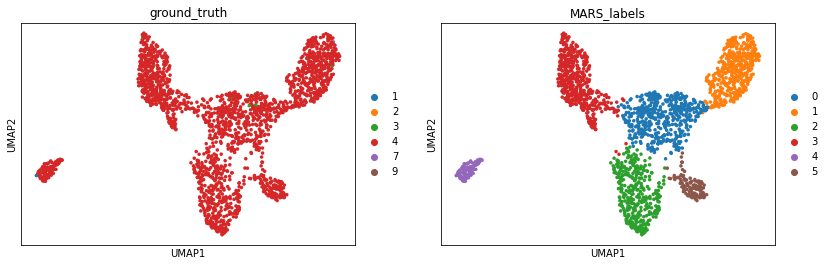

In [160]:
sc.pp.neighbors(adata_mars, n_neighbors=30, use_rep='X')
sc.tl.umap(adata_mars)
sc.pl.umap(adata_mars, color=['ground_truth','MARS_labels'],size=50)